Remove property tax

In [45]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
import math
#import category_encoders as ce
%matplotlib inline

In [281]:
realtor = pd.read_csv(os.path.join(os.getcwd(), 'realtor.csv'))
realtor.shape

(1761, 68)

In [47]:
realtor.head()

,Address1,Address2,propertyID,listingID,propertyType,price,leasePrice,buildingType,neighbourhood,bathrooms,...,Cooling,Heating Type,Exterior Finish,Pool Type,Community Features,Amenities Nearby,Maintenance Fees,Maintenance Management Company,Total Parking Spaces,rooms_info
0,#1407 -5444 YONGE ST,"Toronto, Ontario M2N6J4",23762142,C5411047,SingleFamily,1499999.0,NaN,Apartment,NaN,2,...,Central air conditioning,Forced air (Natural gas),Concrete,"Indoor pool, Outdoor pool",NaN,NaN,"$1,528 (CAD) Monthly",Del Property Management,4.0,{'Main level': {'Living room': '7.3 m x 3.95 m...
1,#606 -300 BALLIOL ST,"Toronto, Ontario M4S3G6",23790906,C5420731,SingleFamily,548800.0,NaN,Apartment,NaN,1,...,Central air conditioning,Heat Pump (Electric),Brick,NaN,School Bus,"Park, Public Transit",$375 (CAD) Monthly,Goldview Property Management Ltd. 416-630-1234,NaN,{'Main level': {'Living room': '5.18 m x 3.05 ...
2,#1207 -5 PARKWAY FOREST DR,"Toronto, Ontario M2J1L2",23834601,C5435290,SingleFamily,549000.0,NaN,Apartment,NaN,1,...,Window air conditioner,Baseboard heaters (Electric),Brick,NaN,NaN,NaN,$674.85 (CAD) Monthly,Tech Lasi Management Service Tel 416-491-4441,1.0,{'Main level': {'Living room': '6.02 m x 3.17 ...
3,#404 -55 WELLESLEY ST E,"Toronto, Ontario M4Y2T6",23788958,C5419896,SingleFamily,939000.0,NaN,Apartment,NaN,2,...,Central air conditioning,Heat Pump (Electric),Brick,NaN,NaN,NaN,"$1,252.96 (CAD) Monthly",Community First Developments. Comfield Managem...,2.0,"{'Main level': {'Foyer': '2.5 m x 1.7 m', 'Liv..."
4,#1707 -375 KING ST W,"Toronto, Ontario M5V1K1",23801653,C5424009,SingleFamily,849000.0,NaN,Apartment,NaN,2,...,Central air conditioning,Forced air (Natural gas),Concrete,NaN,NaN,NaN,$594.63 (CAD) Monthly,Crossbridge Condominium Services - 416-979-0009,NaN,"{'Other': {'Living room': '7.2 m x 3.7 m', 'Di..."


In [282]:
# helper function for extracting the first 3 digits of the post code
def first3post(x):
    if (len(x.split("Ontario "))==2):
        return x.split("Ontario ")[1][:3]
    else:
        return np.nan
    
realtor['postcode3'] = realtor['Address2'].apply(first3post)

In [49]:
# Display columns
print(realtor.columns.tolist())

['Address1', 'Address2', 'propertyID', 'listingID', 'propertyType', 'price', 'leasePrice', 'buildingType', 'neighbourhood', 'bathrooms', 'bedrooms', 'communityFeatures', 'nearbyAmenities', 'storeys', 'walkscore', 'transitscore', 'machineryIncluded', 'rentalEquipment', 'parkingType', 'majorBusinessType', 'minorBusinessType', 'totalUnits', 'landSize', 'zoningType', 'interiorFloorSpace', 'exteriorBuildingSize', 'franchise', 'buildingAmenities', 'buildingStyle', 'basementDevelopment', 'notificationUpdate', 'anchor', 'retailStorefront', 'clearCeilingHeight', 'hasphoto', 'photos', 'multimediaFeatures', 'listingVideoType', 'city', 'province', 'soldData', 'hasAlternateFeatureSheet', 'hasOpenHouse', 'hasVirtualOpenHouse', 'hasCMHCFTHBBanner', 'hasTDpreApprovalIcon', 'hasActiveVirtualOpenHouse', 'Property Type', 'Building Type', 'Community Name', 'Title', 'Annual Property Taxes', 'Parking Type', 'Time on REALTOR.ca', 'Above Grade', 'Total', 'Features', 'Building Amenities', 'Cooling', 'Heating T

In [283]:
col_type = realtor.dtypes
var_cat = col_type[col_type=='object'].index.tolist()
print(var_cat)

['Address1', 'Address2', 'listingID', 'propertyType', 'buildingType', 'neighbourhood', 'communityFeatures', 'nearbyAmenities', 'rentalEquipment', 'parkingType', 'landSize', 'interiorFloorSpace', 'exteriorBuildingSize', 'buildingAmenities', 'buildingStyle', 'basementDevelopment', 'notificationUpdate', 'hasphoto', 'multimediaFeatures', 'listingVideoType', 'city', 'province', 'soldData', 'hasAlternateFeatureSheet', 'hasOpenHouse', 'hasVirtualOpenHouse', 'hasCMHCFTHBBanner', 'hasTDpreApprovalIcon', 'hasActiveVirtualOpenHouse', 'Property Type', 'Building Type', 'Community Name', 'Title', 'Annual Property Taxes', 'Parking Type', 'Time on REALTOR.ca', 'Features', 'Building Amenities', 'Cooling', 'Heating Type', 'Exterior Finish', 'Pool Type', 'Community Features', 'Amenities Nearby', 'Maintenance Fees', 'Maintenance Management Company', 'rooms_info', 'postcode3']


In [284]:
var_num = col_type[col_type!='object'].index.tolist()
print(var_num)

['propertyID', 'price', 'leasePrice', 'bathrooms', 'bedrooms', 'storeys', 'walkscore', 'transitscore', 'machineryIncluded', 'majorBusinessType', 'minorBusinessType', 'totalUnits', 'zoningType', 'franchise', 'anchor', 'retailStorefront', 'clearCeilingHeight', 'photos', 'Above Grade', 'Total', 'Total Parking Spaces']


In [52]:
for i, var in enumerate(var_cat):
    print(str(i) + " - " + str(var) + ":")
    print(realtor[var].value_counts(dropna=False))
    print('-------------------------------------------------------')
    print()

0 - Address1:
#1407 -5444 YONGE ST          1
#619 -801 KING ST W           1
11 WILLIAM POOLE WAY          1
#1414 -1 ROWNTREE RD          1
#402 -645 MILLWOOD RD         1
                             ..
#2903 -183 WELLINGTON ST W    1
#758 -313 RICHMOND ST E       1
#611 -75 EMMETT  AVE          1
#512 -88 GRANDVIEW WAY        1
#604 -25 GRENVILLE ST         1
Name: Address1, Length: 1761, dtype: int64
-------------------------------------------------------

1 - Address2:
Toronto, Ontario M2J1M5    19
Toronto, Ontario           19
Toronto, Ontario M5B0C3    10
Toronto, Ontario M5J2Z2     8
Toronto, Ontario M5V0S2     8
                           ..
Toronto, Ontario M1J3N4     1
Toronto, Ontario M5T2E5     1
Toronto, Ontario M5T0E1     1
Toronto, Ontario M6S2A2     1
Toronto, Ontario M3J1M3     1
Name: Address2, Length: 1023, dtype: int64
-------------------------------------------------------

2 - listingID:
C5411047    1
C5436159    1
C5429066    1
W5419741    1
C5437709    1
     

#### Check Missing Values

In [53]:
realtor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 69 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Address1                        1761 non-null   object 
 1   Address2                        1761 non-null   object 
 2   propertyID                      1761 non-null   int64  
 3   listingID                       1761 non-null   object 
 4   propertyType                    1761 non-null   object 
 5   price                           1761 non-null   float64
 6   leasePrice                      0 non-null      float64
 7   buildingType                    1754 non-null   object 
 8   neighbourhood                   1 non-null      object 
 9   bathrooms                       1761 non-null   int64  
 10  bedrooms                        1753 non-null   float64
 11  communityFeatures               391 non-null    object 
 12  nearbyAmenities                 11

In [285]:
for var in var_cat:
    realtor.loc[realtor[var]=='', var] = np.nan

In [55]:
realtor_copy = realtor.copy()

Missing summary

In [286]:
# missing summary
MissingSummary = pd.concat([realtor.dtypes, realtor.isnull().any(axis=0), realtor.isnull().sum(axis=0)], 
                           axis=1)
# The axis to concatenate along
MissingSummary.columns = ['FeatureType','IsMissing', 'MissingCnt']
MissingSummary

,FeatureType,IsMissing,MissingCnt
Address1,object,False,0
Address2,object,False,0
propertyID,int64,False,0
listingID,object,False,0
propertyType,object,False,0
...,...,...,...
Maintenance Fees,object,True,33
Maintenance Management Company,object,True,47
Total Parking Spaces,float64,True,405
rooms_info,object,False,0


### Data Cleaning

In [287]:
def data_clean(realtor):
    # Drop duplicate columns & Insignificant Columns
    dup_col = ['propertyType', 'buildingType', 'parkingType', 'buildingAmenities', 'Above Grade', 'Total']
    # also drop province since all condo are in Ontario
    useless_col = ['Address1', 'Address2', 'province', 'propertyID', 'listingID', 'notificationUpdate', 
                   'hasphoto', 'photos','Time on REALTOR.ca', 'multimediaFeatures', 'soldData', 'hasAlternateFeatureSheet', 
                   'hasOpenHouse', 'hasVirtualOpenHouse', 'hasCMHCFTHBBanner', 'hasTDpreApprovalIcon', 
                   'hasActiveVirtualOpenHouse']
    realtor = realtor.drop(dup_col, axis=1)
    realtor = realtor.drop(useless_col, axis=1)
    
    MissingSummary = pd.concat([realtor.dtypes, realtor.isnull().any(axis=0), realtor.isnull().sum(axis=0)], 
                           axis=1)
    # The axis to concatenate along
    MissingSummary.columns = ['FeatureType','IsMissing', 'MissingCnt']
    
    DropColumn = MissingSummary[(MissingSummary.MissingCnt/realtor.shape[0]>0.2)].index.tolist()
    realtor = realtor.drop(DropColumn, axis=1)
    
            
    # Drop rows if features are missing
    realtor = realtor.dropna()
    realtor = realtor.reset_index(drop=True)
    # Drop rows not belongs to Apartment
    realtor = realtor[realtor['Building Type']=="Apartment"]
    # Only keep price between [100,000, 3,000,000]
    realtor = realtor[(realtor.price>100000) & (realtor.price<3000000)]
    realtor = realtor[realtor['bedrooms']!=0]
        
    realtor_clean = realtor.copy()
    
    return realtor_clean

In [288]:
realtor_clean = data_clean(realtor_copy)

In [289]:
realtor = realtor_clean.copy()

### Overview the cleaned dataset

In [59]:
col_type = realtor.dtypes
var_cat = col_type[col_type=='object'].index.tolist()
print(var_cat)
print(len(var_cat))

['city', 'Property Type', 'Building Type', 'Community Name', 'Title', 'Annual Property Taxes', 'Parking Type', 'Building Amenities', 'Cooling', 'Heating Type', 'Exterior Finish', 'Maintenance Fees', 'Maintenance Management Company', 'rooms_info', 'postcode3']


In [61]:
var_num = col_type[col_type!='object'].index.tolist()
print(var_num)

['price', 'bathrooms', 'bedrooms']


In [62]:
for i, var in enumerate(var_cat):
    print(str(i) + " - " + str(var) + ":")
    print(realtor[var].value_counts(dropna=False))
    print('-------------------------------------------------------')
    print()

0 - city:
Toronto    1161
Name: city, dtype: int64
-------------------------------------------------------

1 - Property Type:
Single Family    1161
Name: Property Type, dtype: int64
-------------------------------------------------------

2 - Building Type:
Apartment    1161
Name: Building Type, dtype: int64
-------------------------------------------------------

3 - Community Name:
Waterfront Communities C1    171
Church-Yonge Corridor         91
Niagara                       67
Bay Street Corridor           63
Mimico                        59
                            ... 
Humberlea-Pelmo Park W5        1
Weston-Pellam Park             1
Junction Area                  1
Hillcrest Village              1
East York                      1
Name: Community Name, Length: 113, dtype: int64
-------------------------------------------------------

4 - Title:
Condominium/Strata        1141
Undivided Co-ownership      10
Shares in Co-operative      10
Name: Title, dtype: int64
--------------

#### Convert Annual Property Tax & Maintenance Fees to numeric

In [63]:
## helper function
def get_fee(string):
    fee = float(string.replace(',','').split()[0].split("$")[1])
    return fee

#### Categorical Variable Encoding
Reference: https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/  

Target Encoding: https://towardsdatascience.com/handling-categorical-data-the-right-way-9d1279956fc6

In [29]:
# Building Type: 2 - one hot
# Community Name: popular 5, save others as Other (Waterfront, Church-Yonge, Niagara, Bay, Mimico, Other) 
# Title: 3 - dummy encoding
# Parking Type: create new dummy columns (Underground, Visitor, Garage)
# Building Amenities: new dummy columns (Storage, Security, Party, Exercise)
# Cooling: 3 - dummy encoding
# Heating: new (Forced, Pump)
# Exterior Finish: new (Concrete, Brick)
# Maintenance Management Company: new (Del, First Service Residential, Crossbridge, Icon, Duka)

In [72]:
## helper functions for reorganize categorical variables
def get_community(comm):
    if "Waterfront" in comm:
        return "Waterfront"
    elif "Annex" in comm:
        return "Annex"
    elif "Black Creek" in comm:
        return "Black Creek"
#     elif "Church-Yonge" in comm:
#         return "Church-Yonge"
#     elif "Niagara" in comm:
#         return "Niagara"
#     elif "Bay " in comm:
#         return "Bay"
#     elif "Mimico" in comm:
#         return "Mimico"
    else: 
        return "Other"
    
def heat_mech(heat):
    if "Forced air" in heat:
        return "Forced air"
    elif "Heat Pump" in heat:
        return "Heat Pump"
    else:
        return "Other"
    
def heat_material(heat):
    if "Natural gas" in heat:
        return "Natural gas"
    elif "Electric" in heat:
        return "Electric"
    else:
        return "Other"
    
def get_ManageComp(comp):
    if "Del" in comp:
        return "Del"
    elif "First Service Residential" in comp:
        return "First Service Residential"
    elif "Crossbridge" in comp:
        return "Crossbridge"
#     elif "Icon " in comp:
#         return "Icon"
#     elif "Duka" in comp:
#         return "Duka"
    else: 
        return "Other"
    
def find_str(element, string):
    if string in element:
        return 1
    else:
        return 0
    
def get_postcode(code):
    if "M5V" in code:
        return "M5V"
    elif "M2N" in code:
        return "M2N"
    elif "M5A" in code:
        return "M5A"
    elif "M5B" in code:
        return "M5B"
    else: 
        return "Other"

### Data Preprocessing

In [213]:
def process(realtor):
    
    # convert to numeric
    #realtor['num_property_tax'] = realtor['Annual Property Taxes'].apply(get_fee)
    realtor['num_maintenance_fee'] = realtor['Maintenance Fees'].apply(get_fee)
    realtor = realtor[realtor_encoded2['num_maintenance_fee']>2]

    # summarize categorical variables: decrease number of levels
    realtor['community'] = realtor['Community Name'].apply(get_community)
    realtor['heat_mech'] = realtor['Heating Type'].apply(heat_mech)
    realtor['heat_material'] = realtor['Heating Type'].apply(heat_material)
    realtor['ManageComp'] = realtor['Maintenance Management Company'].apply(get_ManageComp)
    realtor['postcode3top'] = realtor['postcode3'].apply(get_postcode) 

    # Parking Type: 
    realtor['park_Underground'] = realtor.apply(lambda x: find_str(x['Parking Type'], 'Underground'), axis=1)
    realtor['park_Visitor'] = realtor.apply(lambda x: find_str(x['Parking Type'], 'Visitor'), axis=1)
    #realtor['park_Garage'] = realtor.apply(lambda x: find_str(x['Parking Type'], 'Garage'), axis=1)
    # Building Amenities: (Storage, Security, Party, Exercise)
    realtor['amenity_Storage'] = realtor.apply(lambda x: find_str(x['Building Amenities'], 'Storage'), axis=1)
    realtor['amenity_Security'] = realtor.apply(lambda x: find_str(x['Building Amenities'], 'Security'), axis=1)
    realtor['amenity_Party'] = realtor.apply(lambda x: find_str(x['Building Amenities'], 'Party'), axis=1)
    realtor['amenity_Exercise'] = realtor.apply(lambda x: find_str(x['Building Amenities'], 'Exercise'), axis=1)
    # Exterior Finish: new (Concrete, Brick)
    realtor['exterior_Concrete'] = realtor.apply(lambda x: find_str(x['Exterior Finish'], 'Concrete'), axis=1)
    realtor['exterior_Brick'] = realtor.apply(lambda x: find_str(x['Exterior Finish'], 'Brick'), axis=1)
    # Building Type
    #realtor['type_Apartment'] = realtor.apply(lambda x: find_str(x['Building Type'], 'Apartment'), axis=1)
    # Title: 3 - dummy encoding
    #realtor['title_Condominium'] = realtor.apply(lambda x: find_str(x['Title'], 'Condominium'), axis=1)
    # Cooling: 3 - dummy encoding
    realtor['cool_Central_air'] = realtor.apply(lambda x: find_str(x['Cooling'], 'Central air'), axis=1)
    
    realtor=pd.get_dummies(data=realtor, columns=['community', 'heat_mech', 'heat_material','ManageComp', 'postcode3top'])
    # drop columns include Other
    other_cols = [col for col in realtor.columns if ('Other' in col)]
    realtor = realtor.drop(other_cols, axis=1)
    
    ## clean columns again
    # drop categorical columns & Other
    drop_cols = ['city', 'Property Type', 'postcode3', 
           'Building Type', 'Community Name', 'Title', 'Annual Property Taxes',
           'Parking Type', 'Building Amenities', 'Cooling', 'Heating Type',
           'Exterior Finish', 'Maintenance Fees', 'Maintenance Management Company',
           'rooms_info']
    realtor = realtor.drop(drop_cols, axis=1)
    
    processed_data = realtor.copy()
    
    return processed_data

In [214]:
realtor_processed = process(realtor)

C:\Users\qingy\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\qingy\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\qingy\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [215]:
def process2(realtor):
    #create dummy variables for all levels in the categorical variables without processing
    
    # convert to numeric
    #realtor['num_property_tax'] = realtor['Annual Property Taxes'].apply(get_fee)
    realtor['num_maintenance_fee'] = realtor['Maintenance Fees'].apply(get_fee)
    realtor = realtor[realtor_encoded2['num_maintenance_fee']>2]

    # summarize categorical variables: decrease number of levels
    realtor['community'] = realtor['Community Name']#.apply(get_community)
    realtor['heat_mech'] = realtor['Heating Type']#.apply(heat_mech)
    realtor['heat_material'] = realtor['Heating Type']#.apply(heat_material)
    realtor['ManageComp'] = realtor['Maintenance Management Company']#.apply(get_ManageComp)
    realtor['postcode3top'] = realtor['postcode3']#.apply(get_postcode) 

    # Parking Type: 
    realtor['park_Underground'] = realtor.apply(lambda x: find_str(x['Parking Type'], 'Underground'), axis=1)
    realtor['park_Visitor'] = realtor.apply(lambda x: find_str(x['Parking Type'], 'Visitor'), axis=1)
    #realtor['park_Garage'] = realtor.apply(lambda x: find_str(x['Parking Type'], 'Garage'), axis=1)
    # Building Amenities: (Storage, Security, Party, Exercise)
    realtor['amenity_Storage'] = realtor.apply(lambda x: find_str(x['Building Amenities'], 'Storage'), axis=1)
    realtor['amenity_Security'] = realtor.apply(lambda x: find_str(x['Building Amenities'], 'Security'), axis=1)
    realtor['amenity_Party'] = realtor.apply(lambda x: find_str(x['Building Amenities'], 'Party'), axis=1)
    realtor['amenity_Exercise'] = realtor.apply(lambda x: find_str(x['Building Amenities'], 'Exercise'), axis=1)
    # Exterior Finish: new (Concrete, Brick)
    realtor['exterior_Concrete'] = realtor.apply(lambda x: find_str(x['Exterior Finish'], 'Concrete'), axis=1)
    realtor['exterior_Brick'] = realtor.apply(lambda x: find_str(x['Exterior Finish'], 'Brick'), axis=1)
    # Building Type
    #realtor['type_Apartment'] = realtor.apply(lambda x: find_str(x['Building Type'], 'Apartment'), axis=1)
    # Title: 3 - dummy encoding
    #realtor['title_Condominium'] = realtor.apply(lambda x: find_str(x['Title'], 'Condominium'), axis=1)
    # Cooling: 3 - dummy encoding
    realtor['cool_Central_air'] = realtor.apply(lambda x: find_str(x['Cooling'], 'Central air'), axis=1)
    
    realtor=pd.get_dummies(data=realtor, columns=['community', 'heat_mech', 'heat_material','ManageComp', 'postcode3top'])
    # drop columns include Other
#     other_cols = [col for col in realtor.columns if ('Other' in col)]

    ## clean columns again
    # drop categorical columns & Other
    drop_cols = ['city', 'Property Type', 'postcode3', 
           'Building Type', 'Community Name', 'Title', 'Annual Property Taxes',
           'Parking Type', 'Building Amenities', 'Cooling', 'Heating Type',
           'Exterior Finish', 'Maintenance Fees', 'Maintenance Management Company',
           'rooms_info']
    realtor = realtor.drop(drop_cols, axis=1)
    
    processed_data = realtor.copy()
    
    return processed_data

In [216]:
realtor_processed2 = process2(realtor)

C:\Users\qingy\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\qingy\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\qingy\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [217]:
realtor_encoded = realtor_processed
realtor_encoded.head()

,price,bathrooms,bedrooms,num_maintenance_fee,park_Underground,park_Visitor,amenity_Storage,amenity_Security,amenity_Party,amenity_Exercise,...,heat_mech_Heat Pump,heat_material_Electric,heat_material_Natural gas,ManageComp_Crossbridge,ManageComp_Del,ManageComp_First Service Residential,postcode3top_M2N,postcode3top_M5A,postcode3top_M5B,postcode3top_M5V
0,1499999.0,2,2.0,1528.00,1,0,0,1,0,1,...,0,0,1,0,1,0,1,0,0,0
1,548800.0,1,1.0,375.00,0,1,1,0,1,1,...,1,1,0,0,0,0,0,0,0,0
2,939000.0,2,2.0,1252.96,1,1,1,0,1,0,...,1,1,0,0,0,0,0,0,0,0
3,849000.0,2,2.0,594.63,1,0,0,1,0,1,...,0,0,1,1,0,0,0,0,0,1
4,749000.0,1,2.0,429.60,1,1,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1


In [218]:
realtor_encoded2 = realtor_processed2
realtor_encoded2.head()

,price,bathrooms,bedrooms,num_maintenance_fee,park_Underground,park_Visitor,amenity_Storage,amenity_Security,amenity_Party,amenity_Exercise,...,postcode3top_M9A,postcode3top_M9B,postcode3top_M9C,postcode3top_M9L,postcode3top_M9M,postcode3top_M9N,postcode3top_M9P,postcode3top_M9R,postcode3top_M9V,postcode3top_M9W
0,1499999.0,2,2.0,1528.00,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,548800.0,1,1.0,375.00,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,939000.0,2,2.0,1252.96,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,849000.0,2,2.0,594.63,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,749000.0,1,2.0,429.60,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


#### Remove tax and fee = 0

In [166]:
#realtor_encoded2 = realtor_encoded.copy()
#realtor_encoded2 = realtor_encoded2[realtor_encoded2['num_property_tax']>2]
#realtor_encoded2 = realtor_encoded2[realtor_encoded2['num_maintenance_fee']>2]
#realtor_encoded2.shape

(1161, 841)

### Visualization

In [86]:
realtor_encoded2.describe().astype(float)

,price,bathrooms,bedrooms,num_maintenance_fee,park_Underground,park_Visitor,amenity_Storage,amenity_Security,amenity_Party,amenity_Exercise,...,heat_material_Electric,heat_material_Natural gas,ManageComp_Crossbridge,ManageComp_Del,ManageComp_First Service Residential,postcode3top_M2N,postcode3top_M5A,postcode3top_M5B,postcode3top_M5V,postcode3top_Other
count,1.157000e+03,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,...,1157.000000,1157.00000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000
mean,8.387084e+05,1.619706,2.030251,729.682169,0.955920,0.514261,0.707865,0.725151,0.584270,0.801210,...,0.066551,0.91357,0.156439,0.155575,0.071737,0.059637,0.057044,0.042351,0.119274,0.721694
std,4.235994e+05,0.611786,0.764673,381.923609,0.205361,0.500013,0.454941,0.446631,0.493061,0.399262,...,0.249351,0.28112,0.363428,0.362608,0.258164,0.236915,0.232027,0.201476,0.324251,0.448359
min,2.790000e+05,1.000000,0.000000,192.940000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.990000e+05,1.000000,2.000000,488.550000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.999000e+05,2.000000,2.000000,640.620000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,8.999000e+05,2.000000,2.000000,849.450000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2.999999e+06,5.000000,6.000000,3653.180000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 1.0, 'Price Distribution with Log Transformation')

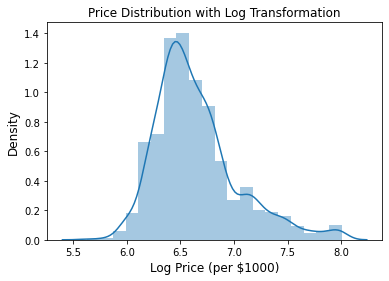

In [236]:
ax = sns.distplot(np.log(realtor_encoded['price']/1000), hist=True, bins=20)
ax.set_xlabel('Log Price (per $1000)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Price Distribution with Log Transformation', fontsize=12)

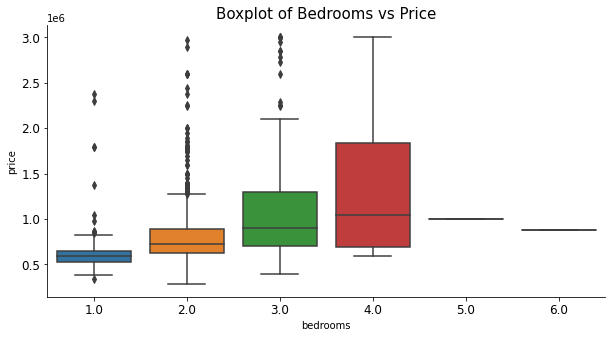

In [291]:
#sns.pairplot(realtor,hue='Building Type')
fig, ax1 = plt.subplots(figsize=(10,5))
sns.boxplot(y='price',x='bedrooms',data=realtor, ax = ax1)
ax1.set_title('Boxplot of Bedrooms vs Price', fontsize=15)
ax1.tick_params(labelsize=12)
sns.despine()

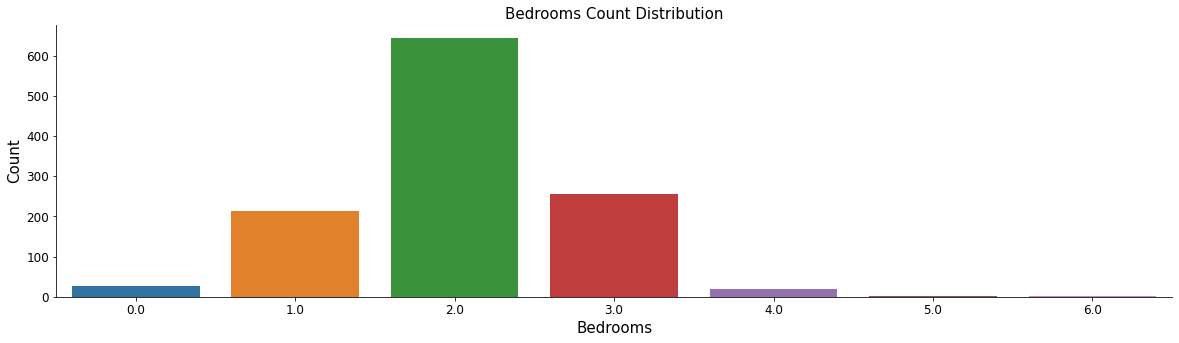

In [89]:
fig, ax1 = plt.subplots(figsize=(20,5))
sns.countplot(x = 'bedrooms', data = realtor, ax = ax1)
ax1.set_xlabel('Bedrooms', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
ax1.set_title('Bedrooms Count Distribution', fontsize=15)
ax1.tick_params(labelsize=12)
sns.despine()

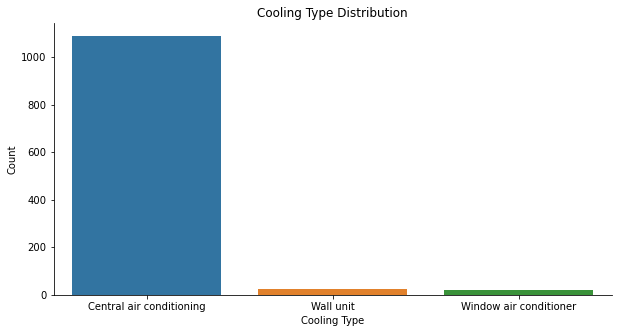

In [293]:
fig, ax1 = plt.subplots(figsize=(10,5))
sns.countplot(x = 'Cooling', data = realtor, ax = ax1)
ax1.set_xlabel('Cooling Type')
ax1.set_ylabel('Count')
ax1.set_title('Cooling Type Distribution')
sns.despine()

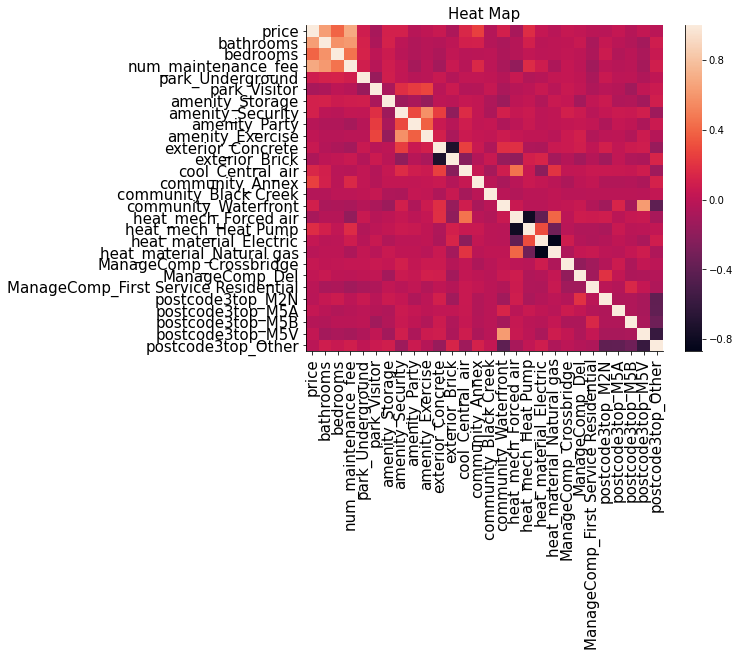

In [90]:
fig, ax1 = plt.subplots(figsize=(8,6))
sns.heatmap(realtor_encoded2.corr())
ax1.tick_params(labelsize=15)
ax1.set_title('Heat Map', fontsize=15)
sns.despine()

### Model: Lasso/Random Forest

Train Test Split

In [260]:
print("Shape: ", realtor_encoded.shape)
X = realtor_encoded.drop("price", axis=1) # drop labels 
y = realtor_encoded["price"].copy()    #/1000
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=24)

Shape:  (1157, 27)


In [223]:
print("Shape: ", realtor_encoded2.shape)
X2 = realtor_encoded2.drop("price", axis=1) # drop labels 
y2 = realtor_encoded2["price"].copy()/1000    #/1000
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=24)

Shape:  (1157, 841)


In [ ]:
# simple model
# realtor['num_property_tax'] = realtor['Annual Property Taxes'].apply(get_fee)
# realtor['num_maintenance_fee'] = realtor['Maintenance Fees'].apply(get_fee)
# realtor_encoded2 = realtor_encoded2[realtor_encoded2['num_property_tax']>2]
# realtor_encoded2 = realtor_encoded2[realtor_encoded2['num_maintenance_fee']>2]

# X2 = realtor_encoded2[['bathrooms','num_property_tax', 'num_maintenance_fee']] # drop labels 
# y2 = realtor_encoded2["price"].copy()    #/1000
# X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.25, random_state=24)

# lreg_simple = LinearRegression()
# lreg_simple.fit(X_train2,y_train2)

# print("LR train R square: %0.3f" % lreg_simple.score(X_train2, y_train2))
# print("LR test R square: %0.3f" % lreg_simple.score(X_test2, y_test2))
# print("LR train RMSE: %0.3f" % np.sqrt(mean_squared_error(lreg_simple.predict(X_train2), y_train2)))
# print("LR test RMSE: %0.3f" % np.sqrt(mean_squared_error(lreg_simple.predict(X_test2), y_test2)))

### Models

In [261]:
# Linear Regression
lreg = LinearRegression()
lreg.fit(X_train,y_train)
coeff_parameter = pd.DataFrame(lreg.coef_,X_train.columns,columns=['Coefficient'])

# log linear regression
log_lreg = LinearRegression()
log_lreg.fit(X_train,np.log(y_train))

# LASSO
lassoReg = linear_model.Lasso()
lassoReg.fit(X_train,y_train)
coeff_lasso = pd.DataFrame(lassoReg.coef_,X_train.columns,columns=['Coefficient'])

# Random Forest
rf_clf = RandomForestRegressor(max_depth=7, random_state=24)
rf_clf.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, random_state=24)

In [272]:
coeff_parameter

,Coefficient
bathrooms,222671.506359
bedrooms,5186.840264
num_maintenance_fee,534.000491
park_Underground,22695.466727
park_Visitor,-31322.199756
amenity_Storage,28158.891675
amenity_Security,72309.072015
amenity_Party,27963.630441
amenity_Exercise,-30972.433208
exterior_Concrete,42771.375587


In [273]:
coeff_lasso

,Coefficient
bathrooms,222672.964199
bedrooms,5183.287228
num_maintenance_fee,534.007380
park_Underground,22666.496043
park_Visitor,-31318.697865
amenity_Storage,28156.895927
amenity_Security,72306.785091
amenity_Party,27958.253241
amenity_Exercise,-30961.569002
exterior_Concrete,42759.299725


#### Tune RF

In [104]:
from sklearn.model_selection import RandomizedSearchCV
random_grid = {
 'max_depth': [5, 7, 10, 20],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 5],
 'n_estimators': [50, 100, 200]}

rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 50, cv = 3, verbose=2, random_state=24)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; to

[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_sampl

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=20, max_features=auto, m

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=50,
                   param_distributions={'max_depth': [5, 7, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [50, 100, 200]},
                   random_state=24, verbose=2)

In [106]:
print(rf_random.best_params_)
print(rf_random.best_estimator_)
best_rf = rf_random.best_estimator_

{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 7}
RandomForestRegressor(max_depth=7, min_samples_split=5, n_estimators=200)


### Model Evaluation

#### RMSE & R Square

In [193]:
y_pred = rf_clf.predict(X_test)
test_RMSE = np.sqrt(mean_squared_error(y_pred, y_test))
test_RMSE
from sklearn.metrics import r2_score
lr_r2 = r2_score(y_test, lreg.predict(X_test))
adj_r2 = 1 - (1-lr_r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print(lr_r2)
print(adj_r2)

-642684344379092.9
338869927036250.5


In [262]:
def get_results(realtor_encoded): 
    X = realtor_encoded.drop("price", axis=1) # drop labels 
    y = realtor_encoded["price"].copy()    #/1000
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=24)
    
    # Linear Regression
    lreg = LinearRegression()
    lreg.fit(X_train,y_train)
    coeff_parameter = pd.DataFrame(lreg.coef_,X_train.columns,columns=['Coefficient'])

    # log linear regression
    log_lreg = LinearRegression()
    log_lreg.fit(X_train,np.log(y_train))

    # LASSO
    lassoReg = linear_model.Lasso()
    lassoReg.fit(X_train,y_train)
    coeff_lasso = pd.DataFrame(lassoReg.coef_,X_train.columns,columns=['Coefficient'])

    # Random Forest
    rf_clf = RandomForestRegressor(max_depth=7, random_state=24)
    rf_clf.fit(X_train, y_train)
    
    # linear regression
    print('linear regression')
    print("LR train R square: %0.3f" % lreg.score(X_train, y_train))
    print("LR test R square: %0.3f" % lreg.score(X_test, y_test))
    print("LR train RMSE: %0.3f" % np.sqrt(mean_squared_error(lreg.predict(X_train), y_train)))
    print("LR test RMSE: %0.3f" % np.sqrt(mean_squared_error(lreg.predict(X_test), y_test)))

    # log regression
    print('log regression')
    print("LR with log transformation train R square: %0.3f" % log_lreg.score(X_train, np.log(y_train)))
    print("LR test log transformation R square: %0.3f" % log_lreg.score(X_test, np.log(y_test)))
    print("Log LR train RMSE: %0.3f" % np.sqrt(mean_squared_error(log_lreg.predict(X_train), y_train)))
    print("Log LR test RMSE: %0.3f" % np.sqrt(mean_squared_error(log_lreg.predict(X_test), y_test)))

    # random forest
    print('random forest')
    print("RF train R square: %0.3f" % rf_clf.score(X_train, y_train))
    print("RF test R square: %0.3f" % rf_clf.score(X_test, y_test))

    # LASSO
    print("LASSO")
    print("Lasso train R square: %0.3f" % lassoReg.score(X_train, y_train))
    print("Lasso test R square: %0.3f" % lassoReg.score(X_test, y_test))

#### Results when preprocessing dummy

In [263]:
get_results(realtor_encoded)

linear regression
LR train R square: 0.613
LR test R square: 0.626
LR train RMSE: 261487.360
LR test RMSE: 264364.445
log regression
LR with log transformation train R square: 0.642
LR test log transformation R square: 0.640
Log LR train RMSE: 938447.264
Log LR test RMSE: 942703.559
random forest
RF train R square: 0.823
RF test R square: 0.625
LASSO
Lasso train R square: 0.613
Lasso test R square: 0.626


#### Dummy Results
If dummy all levels of the categorical variables, number of indep > number of test set
which will cause lr & log lr get a very poor prediction performance

In [226]:
get_results(realtor_encoded2)

linear regression
LR train R square: 0.907
LR test R square: -113339477550806720.000
LR train RMSE: 128.369
LR test RMSE: 145541906453.389
log regression
LR with log transformation train R square: 0.933
LR test log transformation R square: -19453070705853020.000
Log LR train RMSE: 932.367
Log LR test RMSE: 54124190.402
random forest
RF train R square: 0.826
RF test R square: 0.633
LASSO
Lasso train R square: 0.707
Lasso test R square: 0.653


### Feature Selection
https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html

https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3

In [264]:
for name, importance in zip(X_train.columns.tolist(), rf_clf.feature_importances_):
    print('%s = %.3f' %(name, importance))

bathrooms = 0.281
bedrooms = 0.025
num_maintenance_fee = 0.513
park_Underground = 0.000
park_Visitor = 0.011
amenity_Storage = 0.008
amenity_Security = 0.008
amenity_Party = 0.008
amenity_Exercise = 0.006
exterior_Concrete = 0.003
exterior_Brick = 0.006
cool_Central_air = 0.008
community_Annex = 0.036
community_Black Creek = 0.000
community_Waterfront = 0.026
heat_mech_Forced air = 0.003
heat_mech_Heat Pump = 0.003
heat_material_Electric = 0.002
heat_material_Natural gas = 0.003
ManageComp_Crossbridge = 0.008
ManageComp_Del = 0.006
ManageComp_First Service Residential = 0.020
postcode3top_M2N = 0.001
postcode3top_M5A = 0.005
postcode3top_M5B = 0.005
postcode3top_M5V = 0.005


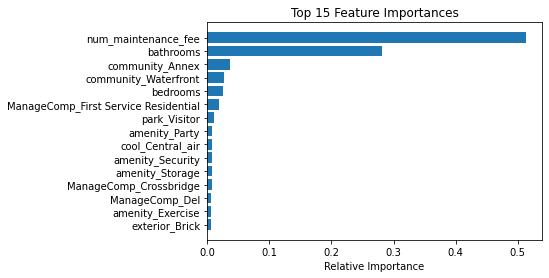

In [265]:
features = X_train.columns.tolist()
importances = rf_clf.feature_importances_
indices = np.argsort(importances)

plt.title('Top 15 Feature Importances')
plt.barh(range(len(indices[-15:])), importances[indices[-15:]], align='center')
plt.yticks(range(len(indices[-15:])), [features[i] for i in indices][-15:])
plt.xlabel('Relative Importance')
plt.show()

In [266]:
#### Select 10 most important features
new_feature = [features[i] for i in indices][-10:]
new_feature

['amenity_Security',
 'cool_Central_air',
 'amenity_Party',
 'park_Visitor',
 'ManageComp_First Service Residential',
 'bedrooms',
 'community_Waterfront',
 'community_Annex',
 'bathrooms',
 'num_maintenance_fee']

In [267]:
[features[i] for i in indices]

['community_Black Creek',
 'park_Underground',
 'postcode3top_M2N',
 'heat_material_Electric',
 'heat_mech_Forced air',
 'heat_material_Natural gas',
 'heat_mech_Heat Pump',
 'exterior_Concrete',
 'postcode3top_M5B',
 'postcode3top_M5A',
 'postcode3top_M5V',
 'exterior_Brick',
 'amenity_Exercise',
 'ManageComp_Del',
 'ManageComp_Crossbridge',
 'amenity_Storage',
 'amenity_Security',
 'cool_Central_air',
 'amenity_Party',
 'park_Visitor',
 'ManageComp_First Service Residential',
 'bedrooms',
 'community_Waterfront',
 'community_Annex',
 'bathrooms',
 'num_maintenance_fee']

#### Visualize tree
https://mljar.com/blog/visualize-tree-from-random-forest/

In [214]:
rf_clf_plot = RandomForestRegressor(max_depth=3, random_state=24)
rf_clf_plot.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, random_state=24)

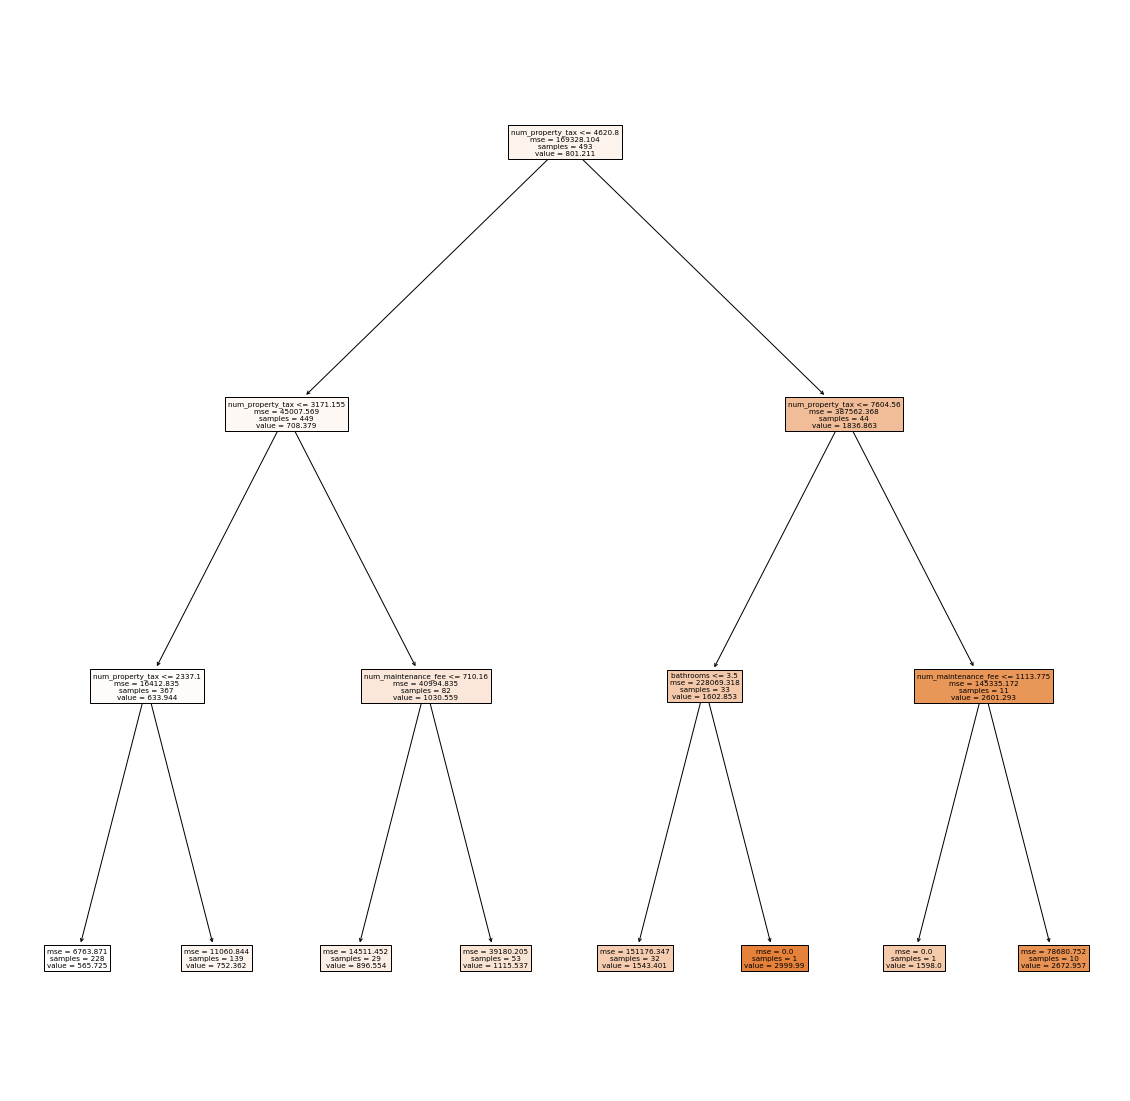

In [215]:
from sklearn import tree
plt.figure(figsize=(20,20))
_ = tree.plot_tree(rf_clf_plot.estimators_[0], feature_names=X.columns, filled=True)

### Fit Model Again After select the Features

In [268]:
rf_clf2 = RandomForestRegressor(max_depth=7, random_state=24)
rf_clf2.fit(X_train[new_feature], y_train)

RandomForestRegressor(max_depth=7, random_state=24)

In [269]:
print("RF train R square: %0.3f" % rf_clf2.score(X_train[new_feature], y_train))
print("RF test R square: %0.3f" % rf_clf2.score(X_test[new_feature], y_test))

RF train R square: 0.817
RF test R square: 0.605


In [270]:
eval_result = []
model_lst = [lreg, log_lreg, lassoReg, rf_clf, rf_clf2]
model_name = ['LR', 'LogLR', 'LASSO', 'RF w/o feature selection', 'RF with feature selection']
for m in model_lst:
    if m == log_lreg:
        trn_r2 = m.score(X_train, np.log(y_train))
        tst_r2 = m.score(X_test, np.log(y_test))
#         trn_rmse = np.sqrt(mean_squared_error(m.predict(X_train), np.log(y_train)))
#         tst_rmse = np.sqrt(mean_squared_error(m.predict(X_test), np.log(y_test)))
        trn_rmse = np.sqrt(mean_squared_error(np.exp(m.predict(X_train)), y_train))
        tst_rmse = np.sqrt(mean_squared_error(np.exp(m.predict(X_test)), y_test))
    elif m== rf_clf2:
        trn_r2 = m.score(X_train[new_feature], y_train)
        tst_r2 = m.score(X_test[new_feature], y_test)
        trn_rmse = np.sqrt(mean_squared_error(m.predict(X_train[new_feature]), y_train))
        tst_rmse = np.sqrt(mean_squared_error(m.predict(X_test[new_feature]), y_test))
    else:
        trn_r2 = m.score(X_train, y_train)
        tst_r2 = m.score(X_test, y_test)
        trn_rmse = np.sqrt(mean_squared_error(m.predict(X_train), y_train))
        tst_rmse = np.sqrt(mean_squared_error(m.predict(X_test), y_test))                           
    
    eval_result.append([trn_r2, tst_r2, trn_rmse, tst_rmse])
    print([trn_r2, tst_r2, trn_rmse, tst_rmse])
    
#pd.DataFrame([model_name,])    

[0.613117049317696, 0.6260520311056852, 261487.36023025718, 264364.44508965826]
[0.6420071264301916, 0.6397041553182641, 260313.58466436362, 303489.49714423454]
[0.6131170415316858, 0.6260485943841918, 261487.3628614706, 264365.65989085875]
[0.8233458538951032, 0.625322300050016, 176694.41502013392, 264622.26293951616]
[0.816923553421838, 0.6048002739152174, 179877.62396290695, 271772.66538677947]


In [271]:
eval_df = pd.DataFrame(eval_result,columns=['Train R Square', 'Test R Square', 'Train RMSE', 'Test RMSE'])
model_df = pd.DataFrame(model_name, columns=['Model'])
eval_df = pd.concat([model_df, eval_df], axis=1)
#eval_df = eval_df.insert(0, 'Model', [1,2,3,4,5])
#eval_df[eval_df['Model']!='LogLR']
eval_df

,Model,Train R Square,Test R Square,Train RMSE,Test RMSE
0,LR,0.613117,0.626052,261487.360230,264364.445090
1,LogLR,0.642007,0.639704,260313.584664,303489.497144
2,LASSO,0.613117,0.626049,261487.362861,264365.659891
3,RF w/o feature selection,0.823346,0.625322,176694.415020,264622.262940
4,RF with feature selection,0.816924,0.604800,179877.623963,271772.665387


In [256]:
np.sqrt(mean_squared_error(np.exp(log_lreg.predict(X_train))*1000, y_train))

866209.212836263

In [246]:
type(log_lreg.predict(X_train))

numpy.ndarray

In [255]:
log_lreg.predict(X_train)

array([6.26518421, 7.33444191, 6.52579938, 7.11454953, 6.78145056,
       6.55297667, 6.70681398, 6.66155415, 6.46776561, 6.30975627,
       6.72270515, 6.50617645, 6.83624514, 6.71857919, 6.70118661,
       6.314455  , 6.88494839, 6.60923875, 6.79296275, 6.29798453,
       6.51311475, 6.76064352, 7.12333995, 6.38522058, 6.34366879,
       6.76577104, 6.80288769, 6.68696719, 6.92520302, 7.05851847,
       6.21958309, 6.78683941, 6.64255975, 6.404138  , 6.79964747,
       6.77225416, 7.41908195, 6.67271025, 6.57487368, 7.44492403,
       6.32994849, 7.05462263, 6.94678136, 6.64780301, 6.40519412,
       6.48084774, 6.70756692, 6.37289839, 6.96187441, 6.34462227,
       6.36780365, 7.06598686, 6.68725639, 6.480775  , 6.2148883 ,
       6.42597536, 6.7134047 , 6.64150262, 6.53377903, 6.84019529,
       6.70871353, 6.43683496, 6.59052737, 6.66181523, 6.20470112,
       6.84362412, 6.91686568, 6.83435904, 6.70152338, 7.24857402,
       6.5557508 , 6.03380359, 7.06275288, 6.30768938, 6.61118

#### Use R like linear regression with ols

In [49]:
ols_drop = ['city', 'Property Type','Building Type', 'Community Name', 'Title', 'Annual Property Taxes',
       'Parking Type', 'Building Amenities', 'Cooling', 'Heating Type',
       'Exterior Finish', 'Maintenance Fees', 'Maintenance Management Company',
       'rooms_info']
realtor_ols = realtor.copy()
realtor_ols = realtor_ols.drop(ols_drop, axis=1) 

In [50]:
X_ols =  realtor_ols.drop("price", axis=1) # drop labels 
y_ols =  realtor_ols["price"].copy()

In [51]:
X_train_ols, X_test_ols, y_train_ols, y_test_ols = train_test_split(X_ols, y_ols, test_size=0.25, random_state=24)
ols_train = pd.concat([ pd.DataFrame(y_train_ols), X_train_ols], axis=1)
ols_test = pd.concat([pd.DataFrame(y_test_ols), X_test_ols], axis=1)

In [52]:
ols_col = realtor_ols.columns.tolist()
str = 'bathrooms '
for i in range(2, len(ols_col)):
    str += "+ " + ols_col[i] 
    
print(str)

bathrooms + bedrooms+ num_property_tax+ num_maintenance_fee+ community+ heat_mech+ heat_material+ ManageComp+ park_Underground+ park_Visitor+ park_Garage+ amenity_Storage+ amenity_Security+ amenity_Party+ amenity_Exercise+ exterior_Concrete+ exterior_Brick+ type_Apartment+ title_Condominium+ cool_Central_air


In [53]:
X_train_ols.shape

(933, 20)

In [54]:
ols_model = ols('np.log(price) ~ bathrooms + bedrooms+ num_property_tax+ num_maintenance_fee+ C(community)+ C(heat_mech)+ C(heat_material)+ C(ManageComp) + park_Underground+ park_Visitor+ park_Garage+ amenity_Storage+ amenity_Security+ amenity_Party+ amenity_Exercise+ exterior_Concrete+ exterior_Brick+ type_Apartment+ title_Condominium+ cool_Central_air', 
                data=ols_train)
fitted_model = ols_model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     65.82
Date:                Sat, 27 Nov 2021   Prob (F-statistic):          7.75e-204
Time:                        15:19:17   Log-Likelihood:                -46.226
No. Observations:                 933   AIC:                             154.5
Df Residuals:                     902   BIC:                             304.4
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                     12.9410      0.146     88.690      0.000      12.655      13.227
C(community)[T.Church-Yonge]                  -0.0555      0.050     -1.113      0.266      -0.153       0.042
C(community)[T.Mimico]                        -0.1548      0.053     -2.897      0.004      -0.260      -0.050
C(community)[T.Niagara]                       -0.0766      0.052     -1.474      0.141      -0.179       0.025
C(community)[T.Other]                         -0.1589      0.041     -3.873      0.000      -0.239      -0.078
C(community)[T.Waterfront]                     0.0077      0.044      0.176      0.860      -0.078       0.094
C(heat_mech)[T.Heat Pump]                      0.0702      0.034      2.082      0.038       0.004       0.136
C(heat_mech)[T.Other]                          0.0881      0.078      1.127      0.260      -0.065       0.242
C(heat_material)[T.Natural gas]               -0.0624      0.038     -1.660      0.097      -0.136       0.011
C(heat_material)[T.Other]                     -0.1065      0.072     -1.486      0.138      -0.247       0.034
C(ManageComp)[T.Del]                          -0.0581      0.032     -1.838      0.066      -0.120       0.004
C(ManageComp)[T.Duka]                          0.0219      0.047      0.465      0.642      -0.071       0.114
C(ManageComp)[T.First Service Residential]    -0.0051      0.040     -0.126      0.900      -0.084       0.074
C(ManageComp)[T.Icon]                         -0.0003      0.044     -0.008      0.994      -0.087       0.086
C(ManageComp)[T.Other]                        -0.0706      0.026     -2.766      0.006      -0.121      -0.021
bathrooms                                      0.2274      0.020     11.565      0.000       0.189       0.266
bedrooms                                       0.0615      0.014      4.443      0.000       0.034       0.089
num_property_tax                            6.634e-05   5.99e-06     11.069      0.000    5.46e-05    7.81e-05
num_maintenance_fee                            0.0002   3.09e-05      5.115      0.000    9.73e-05       0.000
park_Underground                               0.0464      0.049      0.947      0.344      -0.050       0.142
park_Visitor                                  -0.0143      0.019     -0.752      0.452      -0.051       0.023
park_Garage                                    0.0116      0.094      0.124      0.901      -0.172       0.195
amenity_Storage                                0.0440      0.020      2.227      0.026       0.005       0.083
amenity_Security                               0.0210      0.025      0.851      0.395      -0.027       0.069
amenity_Party                                  0.0112      0.019      0.578      0.563

In [55]:
import statsmodels.api as sm
X_train_Sm= sm.add_constant(X_train)
ls=sm.OLS(y_train,X_train_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     91.69
Date:                Sat, 27 Nov 2021   Prob (F-statistic):          4.55e-250
Time:                        15:19:18   Log-Likelihood:                -6634.9
No. Observations:                 933   AIC:                         1.333e+04
Df Residuals:                     902   BIC:                         1.348e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [57]:
!pip install mlxtend

#### Backward Selection

Reference: https://www.analyticsvidhya.com/blog/2021/04/backward-feature-elimination-and-its-implementation/
https://scikit-learn.org/0.24/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html

scikit-learn does not seem to have a forward selection algorithm. However, it does provide recursive feature elimination, which is a greedy feature elimination algorithm similar to sequential backward selection.
https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-a-forward-selection-stepwise-regression-algorithm

Feature Selection using Wrapper methods
https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/

In [58]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
sfs1 = sfs(lreg, k_features=10, forward=False, floating=False, scoring='neg_mean_squared_error')
sfs1 = sfs1.fit(X_train, y_train)

In [59]:
feat_names = list(sfs1.k_feature_names_)
print(feat_names)

['bathrooms', 'num_property_tax', 'num_maintenance_fee', 'amenity_Party', 'title_Condominium', 'cool_Central_air', 'community_Waterfront', 'heat_mech_Forced air', 'ManageComp_Duka', 'ManageComp_First Service Residential']


In [60]:
# find best number of features 
sfs_op = sfs(LinearRegression(), k_features=(5,15), forward=True, floating=True, scoring='r2')
sfs_op = sfs_op.fit(X_train, y_train)

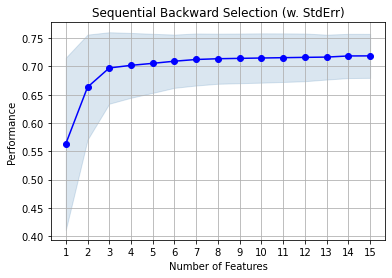

In [61]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs_op.get_metric_dict(), kind='std_dev')
plt.title('Sequential Backward Selection (w. StdErr)')
plt.grid()
plt.show()

In [62]:
sfs_op.get_metric_dict()

{1: {'feature_idx': (2,),
  'cv_scores': array([0.30755205, 0.61837406, 0.53136278, 0.77829312, 0.58064586]),
  'avg_score': 0.5632455754503871,
  'feature_names': ('num_property_tax',),
  'ci_bound': 0.19575538167874812,
  'std_dev': 0.15230433739977176,
  'std_err': 0.07615216869988588},
 2: {'feature_idx': (0, 2),
  'cv_scores': array([0.54412872, 0.69648827, 0.60405437, 0.81903051, 0.6535593 ]),
  'avg_score': 0.6634522338704147,
  'feature_names': ('bathrooms', 'num_property_tax'),
  'ci_bound': 0.11941460581659127,
  'std_dev': 0.09290862023194812,
  'std_err': 0.04645431011597406},
 3: {'feature_idx': (0, 2, 3),
  'cv_scores': array([0.60000043, 0.71513388, 0.6562348 , 0.7819832 , 0.73351081]),
  'avg_score': 0.6973726225764937,
  'feature_names': ('bathrooms', 'num_property_tax', 'num_maintenance_fee'),
  'ci_bound': 0.0811954930510504,
  'std_dev': 0.06317285207148174,
  'std_err': 0.03158642603574087},
 4: {'feature_idx': (0, 2, 3, 22),
  'cv_scores': array([0.61553645, 0.718

In [63]:
sfs2 = sfs(log_lreg, k_features=10, forward=False, scoring='neg_mean_squared_error')
sfs2 = sfs2.fit(X_train, y_train)

In [64]:
feat_names2 = list(sfs2.k_feature_names_)
print(feat_names2)

['bathrooms', 'num_property_tax', 'num_maintenance_fee', 'amenity_Party', 'title_Condominium', 'cool_Central_air', 'community_Waterfront', 'heat_mech_Forced air', 'ManageComp_Duka', 'ManageComp_First Service Residential']


### LightGBM
Handle Categorical Variables

lgbm wont accept categorical data in object format or string format you have to convert that to categorical type

Reference: https://medium.com/analytics-vidhya/lightgbm-for-regression-with-categorical-data-b08eaff501d1

In [68]:
gbm_drop = ['city', 'Property Type','Building Type', 'Community Name', 'Title', 'Annual Property Taxes',
       'Parking Type', 'Building Amenities', 'Cooling', 'Heating Type',
       'Exterior Finish', 'Maintenance Fees', 'Maintenance Management Company',
       'rooms_info']
realtor_gbm = realtor.copy()
realtor_gbm = realtor_gbm.drop(gbm_drop, axis=1) 
realtor_gbm.head()

,price,bathrooms,bedrooms,num_property_tax,num_maintenance_fee,community,heat_mech,heat_material,ManageComp,park_Underground,...,park_Garage,amenity_Storage,amenity_Security,amenity_Party,amenity_Exercise,exterior_Concrete,exterior_Brick,type_Apartment,title_Condominium,cool_Central_air
0,1499999.0,2,2.0,3623.00,1528.00,Other,Forced air,Natural gas,Del,1,...,0,0,1,0,1,1,0,1,1,1
1,548800.0,1,1.0,1912.47,375.00,Other,Heat Pump,Electric,Other,0,...,0,1,0,1,1,0,1,1,1,1
2,939000.0,2,2.0,3207.82,1252.96,Church-Yonge,Heat Pump,Electric,Other,1,...,0,1,0,1,0,0,1,1,1,1
3,849000.0,2,2.0,3250.59,594.63,Waterfront,Forced air,Natural gas,Crossbridge,1,...,0,0,1,0,1,1,0,1,1,1
4,749000.0,1,2.0,2712.90,429.60,Waterfront,Forced air,Natural gas,Del,1,...,0,1,1,0,1,1,0,1,1,1


In [69]:
gbm_col_type = realtor_gbm.dtypes
obj_feat = gbm_col_type[gbm_col_type=='object'].index.tolist()
obj_feat

['community', 'heat_mech', 'heat_material', 'ManageComp']

In [70]:
## change categorical variable type from object to categorical
for feature in obj_feat:
     realtor_gbm[feature] = pd.Series( realtor_gbm[feature], dtype="category")

In [71]:
X2 =  realtor_gbm.drop("price", axis=1) # drop labels 
y2 =  realtor_gbm["price"].copy()

In [72]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.25, random_state=24)

In [73]:
gbm = lgb.LGBMRegressor(learning_rate=0.05,n_estimators=100,seed=24,max_depth=3,min_child_weight = .9,
                             min_child_samples=40,num_leaves=50, objective='regression')

gbm.fit(X_train2, y_train2)

LGBMRegressor(learning_rate=0.05, max_depth=3, min_child_samples=40,
              min_child_weight=0.9, num_leaves=50, objective='regression',
              seed=24)